## Optimization Figures

This notebook contains code for generating figures related to illumination optimization. First, a 3d visualization of the intersection of box constraints and throughput constraints. Then, a (box and whisker?) plot displaying the conditioning for different generation methods.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt


import numpy as np
import llops as yp
import libwallerlab.projects.motiondeblur as md
import ndoperators as ops
from libwallerlab.projects.motiondeblur import bluranalysis  as analysis
import scipy as sp
import os

from matplotlib import cm
plt.style.use('/home/deansarah/.config/matplotlib/deblur.mplstyle')


/home/deansarah/deblurring/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  app.launch_new_instance()
/home/deansarah/deblurring/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  app.launch_new_instance()
/home/deansarah/deblurring/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  app.launch_new_instance()
/home/deansarah/deblurring/venv/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/deansarah/deblurring/venv/lib/python3.6/_collections_abc.py:841: MatplotlibDepre

In [2]:
label_font_size = 22
legend_font_size = 20
figure_output_directory = os.path.expanduser('~/Dropbox/Berkeley/Phase-Deblurring/journalpaper/figures')
figure_output_directory = os.path.expanduser('~/Dropbox/deblurring/Phase-Deblurring/journalpaper/figures')

In [3]:
n_colors = 4
color_coeff = 1.5 #1.75
colors = cm.get_cmap('viridis', int(n_colors*color_coeff))
colors = [colors(i) for i in range(int(n_colors*(1/color_coeff)), int(n_colors*(1 + 1/color_coeff)))]
names = list(reversed(['Constant', 'Greyscale', 'Binary', 'PGD']))

colors = 'dodgerblue', 'limegreen', 'tomato', 'k'
# colors = 'c', 'm', 'y', 'k'
# colors = 'mediumblue', 'green', 'firebrick', 'k'
# colors = [(1, 1, 0, 1), (1, 0, 1, 1), (0, 1, 1, 1), (0, 0, 0, 1)]


## Optimization Results

Comparison of DNF for random search on uniform, random search on binary, and PGD.

In [4]:
system_params = analysis.getDefaultSystemParams()
image_length = system_params['pixel_count'][system_params['motion_axis']]

object_shape = (image_length,)
n_pulses = 25
throughput = 0.5
blur_kernel_length = int(n_pulses / throughput)

blurmapcols = []
for i in range(blur_kernel_length):
    ei = np.zeros(blur_kernel_length)
    ei[i] = 1
    blurmapcols.append(yp.Ft(ei))

def blurMapCol(i):
    return blurmapcols[i]

def get_dnfs_by_method(method, num_it):
    if method in ['uniform', 'coded']:
        return analysis.getOptimalDnf(blur_kernel_length, beta=throughput, n_tests=num_it, 
                                    padding_size=(image_length-blur_kernel_length), metric='dnf', method=method)
    elif method in ['pgd']:
        result = md.blurkernel.genIllum(blurMapCol, blur_kernel_length, throughputCoeff=throughput, DNF=True, verbose=True,
             usePureRandInit=False, maxiter=num_it, resultType='final')
        illum = result['xopt']
        kernel = md.blurkernel.fromVector(illum, object_shape)
        return analysis.calcDnfFromKernel(kernel)
    else:
        assert False, "Error, method name not recognized!"

methods = ['uniform', 'coded', 'pgd', 'pgd']

In [5]:
## testing timing:
from timeit import default_timer as timer
average_times = []
for method in methods[:-1]:
    start = timer()
    get_dnfs_by_method(method, 1000)
    total_time = timer() - start
    print(method, 'took ', total_time)
#     average_times.append(total_time / 10)
# print(average_times[-1] / np.mean(average_times[:-2]) )

uniform took  0.3097511650121305
coded took  0.37886696797795594
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 pgd took  0.2692913630162366


In [6]:
random_its = 1000
num_its = [random_its, random_its, int(random_its/100), random_its]

opt_method_list = list(zip(methods, num_its))
label_list = []
for method, it in opt_method_list:
    if method == 'pgd':
        label_list.append('PGD')
    else:
        label_list.append(method.title())
num_trials = 100

label_list = ['Greyscale\nRandom\nSearch\n(0.5s)', 'Binary\nRandom\nSearch\n(0.5s)', '',
              'Projected\nGradient\nDescent\n(10s)']
print(label_list)


['Greyscale\nRandom\nSearch\n(0.5s)', 'Binary\nRandom\nSearch\n(0.5s)', '', 'Projected\nGradient\nDescent\n(10s)']


In [7]:
try:
    data = np.load('dnf_v_method.npz')
    res_array = data['res_array']
#     label_list = data['label_list']
except FileNotFoundError:
    res = []
    for method, num_it in opt_method_list:
        dnfs = []
        for i in range(num_trials):
            dnfs.append(get_dnfs_by_method(method, num_it))
        print(method, np.mean(dnfs), np.amin(dnfs))
        res.append(dnfs)
    res_array = np.array(res).T
    
    np.savez('dnf_v_method.npz',res_array=res_array, label_list=label_list)

<IPython.core.display.Javascript object>


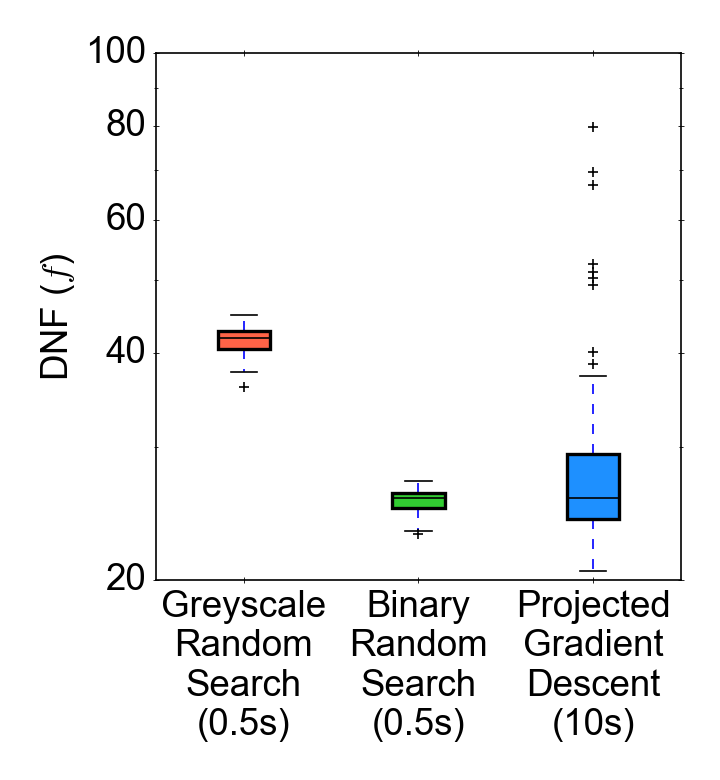

In [8]:

plt.figure(figsize=(6,6.5));
ax = plt.subplot(1,1,1)

def plot_boxplots(ax):

    bplot = ax.boxplot([res_array[:,i] for i in [0,1,3]], labels=[label_list[i] for i in [0,1,3]], patch_artist=True, boxprops={'linewidth': 2})
    # fill with colors
    for patch, color in zip(bplot['boxes'], list(reversed(colors[:-1]))):
        patch.set_facecolor(color)
        patch.set_edgecolor('k')
    for line in bplot['medians']:
        line.set_color('black')

    ax.set_yscale('log')
    ax.set_ylabel('DNF ($f$)', fontsize=label_font_size)
    ax.set_ylim([1e1,1e2])
    
    ax.yaxis.label.set_size(label_font_size)
    ax.xaxis.label.set_size(label_font_size)
    ax.yaxis.set_ticks(np.arange(20,120,20))
    ax.yaxis.set_ticklabels(np.arange(20,120,20))
    ax.set_ylim([2e1,1e2])
    for tick in list(ax.xaxis.get_major_ticks()) + list(ax.yaxis.get_major_ticks()):
        tick.label.set_fontsize(label_font_size) 
    
plot_boxplots(ax)
plt.tight_layout()
plt.savefig(os.path.join(figure_output_directory, 'fig_illum_opt_box.pdf'), transparent=True)

# Illustrative example of good and bad illumination sequences

In [9]:
# t = d / v = (ps/mag)/v
time_per_pixel = system_params['pixel_size'] / system_params['magnification'] / system_params['motion_velocity']

In [10]:

## Greyscale illumination
dnf_grey, kernel_grey = analysis.genBlurVector(blur_kernel_length, beta=throughput, n_tests=1, metric='dnf', 
                          padding_size=(image_length-blur_kernel_length),method='uniform')
illum_ind = np.where(kernel_grey>0)
illum_grey = kernel_grey[illum_ind]

## Constant illumination
kernel_constant = np.zeros_like(kernel_grey)
kernel_constant[illum_ind] = 1.0
dnf_constant = analysis.calcDnfFromKernel(kernel_constant)
illum_constant = kernel_constant[illum_ind]

## Binary illumination
dnf_binary, kernel_binary = analysis.genBlurVector(blur_kernel_length, beta=throughput,n_tests=300,metric='dnf', 
                          padding_size=(image_length-blur_kernel_length),method='coded')
illum_binary = kernel_binary[illum_ind]

## PGD illumination
result = md.blurkernel.genIllum(blurMapCol, blur_kernel_length, throughputCoeff=0.5, DNF=True, verbose=True,
             usePureRandInit=False, maxiter=100, resultType='final', init=illum_binary)
illum_pgd = result['xopt']
kernel_pgd = md.blurkernel.fromVector(illum_pgd, object_shape)
dnf_pgd = analysis.calcDnfFromKernel(kernel_pgd)



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 

In [11]:

illums = list(reversed([illum_constant, illum_grey, illum_binary, illum_pgd]))
# illums = [illum_constant, illum_grey, illum_binary, illum_pgd]
kernels = list(reversed([kernel_constant, kernel_grey, kernel_binary, kernel_pgd]))
# kernels = [kernel_constant, kernel_grey, kernel_binary, kernel_pgd]

# np.savez('example_kernels.npz', kernel_bad=kernel_bad, kernel_good=kernel_good)

<IPython.core.display.Javascript object>


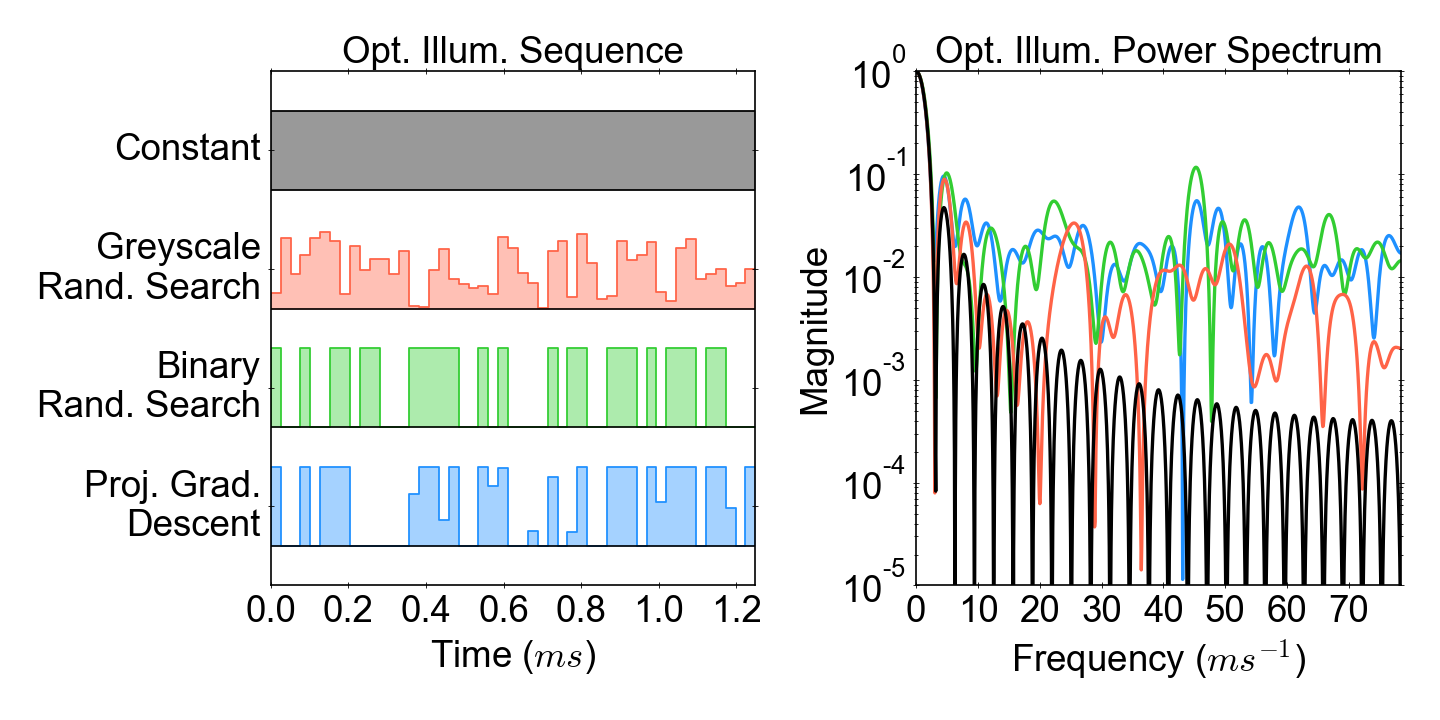

In [35]:
plt.figure(figsize=(12,6))

# Illumination
ax = plt.subplot(1,2,1); 

names = list(reversed(['Constant', 'Greyscale\nRand. Search', 'Binary\nRand. Search', 'Proj. Grad.\nDescent']))

def plot_illum_patterns(ax):

    for i, illum in enumerate(illums):
        illum_time = np.arange(len(illum)) * time_per_pixel * 1e6

        ax.fill_between(illum_time,1.5*i,illum+1.5*i, step="pre", alpha=0.4, color=colors[i])
        ax.plot(illum_time,illum+1.5*i, drawstyle="steps",  color=colors[i])
        ax.plot(illum_time,1.5*i*np.ones_like(illum_time),color='black')

    ax.set_ylim([-0.5,1.5 * (len(illums))])
    # ax.set_ylabel('Intensity'); 
    ax.set_xlabel('Time ($ms$)', fontsize=label_font_size);
    ax.set_xlim(np.amin(illum_time), np.amax(illum_time))

    ax.set_yticks([1.5*i+0.5 for i in range(len(illums))])
    ax.set_yticklabels(names, fontsize=label_font_size)
#     ax.set_yticklabels([])
    ax.set_title('Opt. Illum. Sequence', fontsize=label_font_size)
    for tick in list(ax.xaxis.get_major_ticks()) + list(ax.yaxis.get_major_ticks()):
        tick.label.set_fontsize(label_font_size)     

plot_illum_patterns(ax)
   
# Power Spectrum
ax = plt.subplot(1,2,2); 

label_list_const = ['Constant', 'Grayscale Random Search', 'Binary Random Search', 'Projected Gradient Descent']

def plot_power_spectrums(ax):

    for i, kernel in enumerate(kernels):
        # print(int(0.25*len(kernel)),int(.75*len(kernel)))
        # print(kernel[int(0.25*len(kernel)):int(0.75*len(kernel))])
        #kernel = kernel[int(0.42*len(kernel)):int(0.58*len(kernel))]
        Fkernel_abs = np.abs(yp.Ft(kernel))**2

        freq = np.arange(len(Fkernel_abs))
        freq = freq - freq[len(freq)//2]
        freq = freq * system_params['magnification'] / (len(freq) * system_params['pixel_size'] )  / 10000

        ax.semilogy(freq,Fkernel_abs[:]/np.amax(Fkernel_abs), label=label_list_const[i],color=colors[i], linewidth=2); 
    ax.set_ylim([1e-5,1])
    ax.set_xlim(freq[len(freq)//2], np.amax(freq))

    ax.set_ylabel('Magnitude', fontsize=label_font_size); 
    ax.set_xlabel('Frequency ($ms^{-1}$)', fontsize=label_font_size); 
    ax.set_title('Opt. Illum. Power Spectrum', fontsize=label_font_size)
    for tick in list(ax.xaxis.get_major_ticks()) + list(ax.yaxis.get_major_ticks()):
        tick.label.set_fontsize(label_font_size) 
        
#         ax.legend(fontsize=15, loc='lower left')
   
plot_power_spectrums(ax)
plt.tight_layout()
plt.savefig(os.path.join(figure_output_directory, 'fig_illum_opt_spectrum.pdf'), transparent=True)

# DNF vs Gamma (number of pulses)

In [36]:

try:
    data = np.load('dnf_v_pulse_count.npz')
    dnf_list = data['dnf_list']
    pulse_count_list = data['pulse_count_list']
except FileNotFoundError:
    pulse_count_list = np.arange(10,500)

    dnf_list = [];
    for pulse_count in pulse_count_list:
        res = analysis.getOptimalDnf(2*pulse_count, n_pulses=pulse_count, n_tests=1000, 
                                               padding_size=0, metric='dnf')
        dnf_list.append(res); 
    np.savez('dnf_v_pulse_count.npz', dnf_list=dnf_list, pulse_count_list=pulse_count_list)

standard error 1.0750246865012973
[0.64141481 1.11653804]


<IPython.core.display.Javascript object>


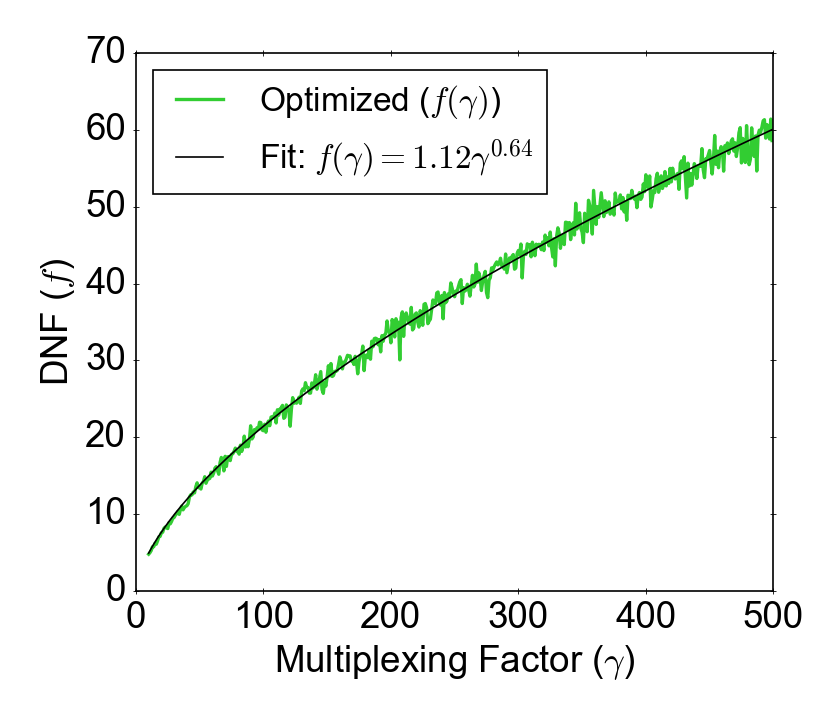

In [37]:
# Perform log fit
# Use standard error http://blog.minitab.com/blog/adventures-in-statistics-2/why-is-there-no-r-squared-for-nonlinear-regression


def func_powerlaw(x, m0, m1):
    return m1 * x**m0 
try:
    data = np.load('dnf_power_law.npz')
    coeffs = data['coeffs']
    pcov = data['pcov']
except FileNotFoundError:
    coeffs, pcov = sp.optimize.curve_fit(func_powerlaw, pulse_count_list, np.array(dnf_list), maxfev=3000 )
    print(coeffs, pcov)
    np.savez('dnf_power_law.npz', coeffs=coeffs, pcov=pcov)


y_p = func_powerlaw(pulse_count_list, *coeffs)
standard_error = np.sqrt(np.mean((dnf_list - y_p)**2) )
print('standard error', standard_error)
print(coeffs)


plt.figure(figsize=(7,6))
ax = plt.subplot(1,1,1)

def plot_dnfs(ax):
    ax.plot(pulse_count_list, dnf_list, label='Optimized ($f(\gamma)$)', color='limegreen', linewidth=2)
    ax.plot(pulse_count_list, (y_p), 
            label='Fit: $f(\gamma)=' + str(np.round(coeffs[1],2))+ ' \gamma^{' + str(np.round(coeffs[0],2)) + '}$',
            color='black')
    ax.set_xlabel('Multiplexing Factor ($\gamma$)', fontsize=label_font_size)
    ax.set_ylabel('DNF ($f$)', fontsize=label_font_size)
    ax.legend(loc='best', fontsize=legend_font_size)

    for tick in list(ax.xaxis.get_major_ticks()) + list(ax.yaxis.get_major_ticks()):
        tick.label.set_fontsize(label_font_size) 

    
plot_dnfs(ax)
plt.tight_layout()
plt.savefig(os.path.join(figure_output_directory, 'fig_illum_opt_dnf.pdf'), transparent=True)

# Plotting Together!

<IPython.core.display.Javascript object>


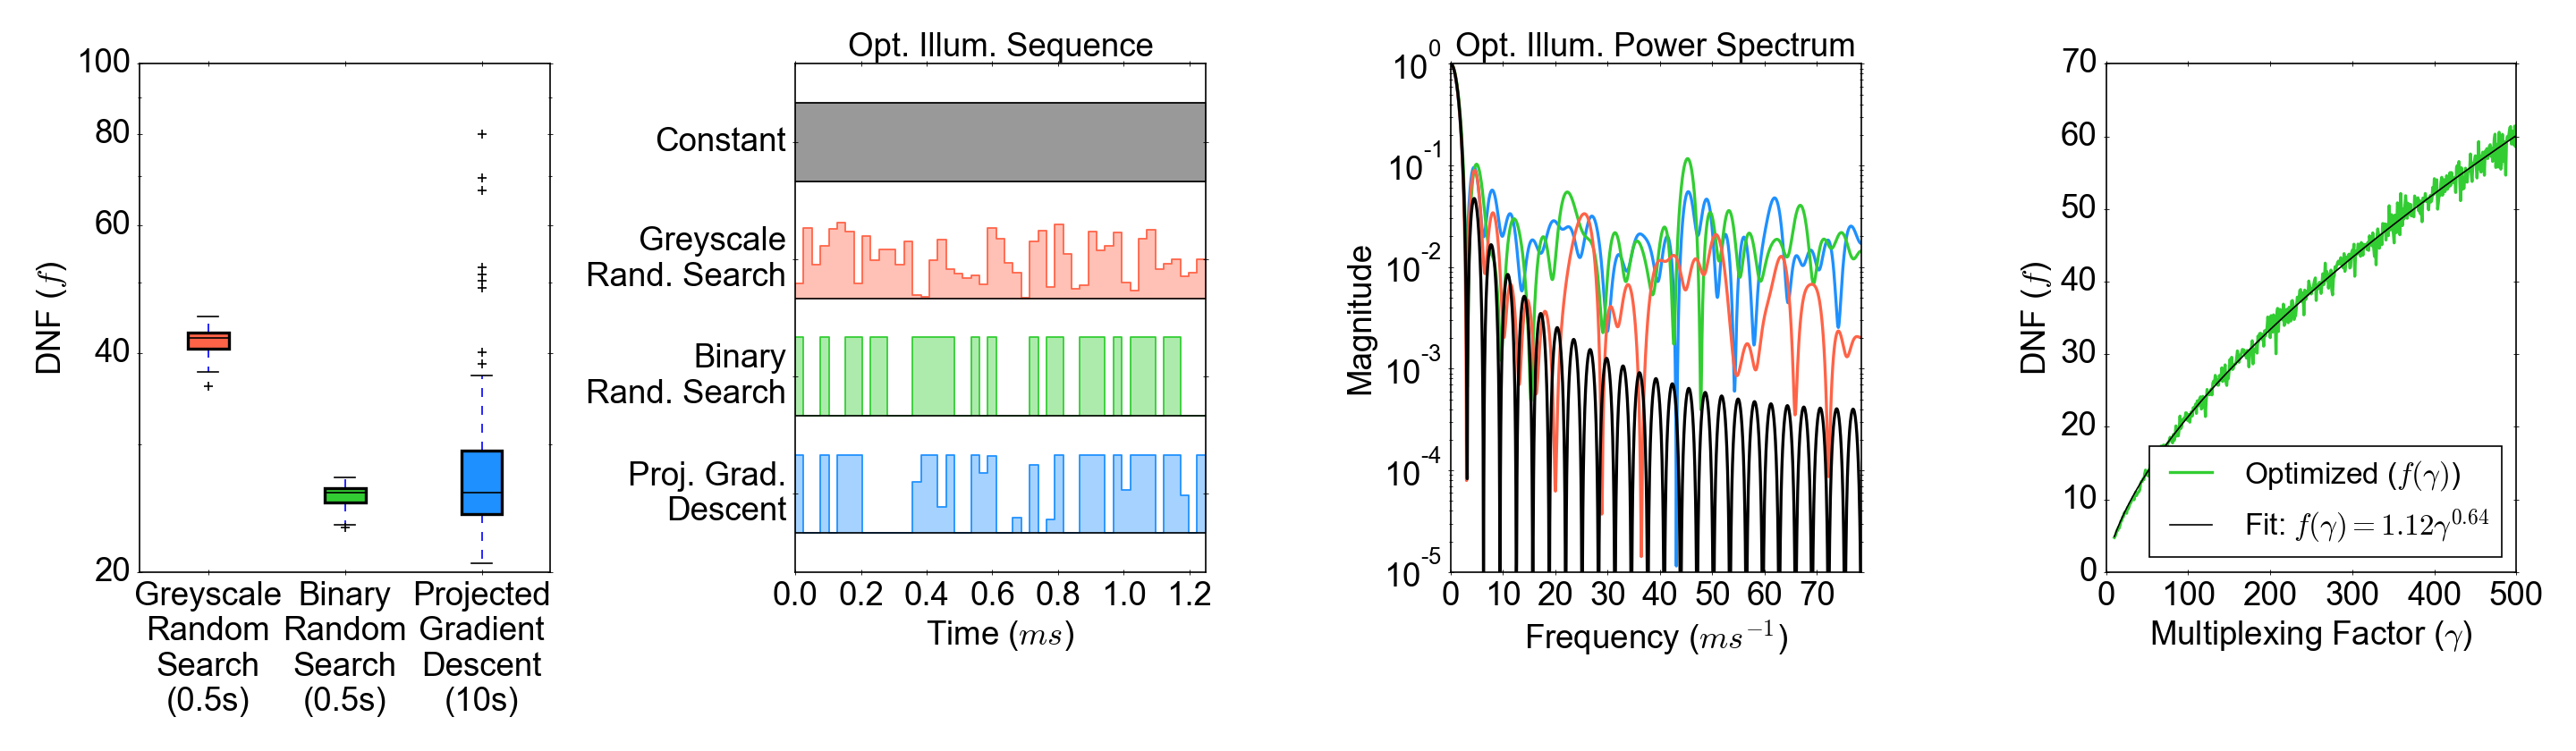

In [38]:
# plt.figure(figsize=(20,10))
plt.figure(figsize=(24,7))
# ax1 = plt.subplot2grid((2,3), (0, 0), colspan=1, rowspan=2)
# ax2 = plt.subplot2grid((2, 3), (0, 1), rowspan=1, colspan=1)
# ax3 = plt.subplot2grid((2, 3), (0, 2), rowspan=1, colspan=1)
# ax4 = plt.subplot2grid((2, 3), (1, 1), rowspan=1, colspan=2)

ax1 = plt.subplot(1,4,1)
ax2 = plt.subplot(1,4,2)
ax3 = plt.subplot(1,4,3)
ax4 = plt.subplot(1,4,4)

# ######## Optimization Method #########
plot_boxplots(ax1)

# ######## Example Illums #########
plot_illum_patterns(ax2)
    
plot_power_spectrums(ax3)

# ######## DNF Law #########
plot_dnfs(ax4)

plt.tight_layout()


In [39]:
figure_directory = '/home/deansarah/Dropbox/deblurring/Phase-Deblurring/journalpaper/figures/'
plt.savefig(figure_directory + 'fig_illumination_full.pdf')